# <b>Bulldozer Prices Notebook</b>

This notebook will take us through EDA, modelling and experimentation on the <a href="https://www.kaggle.com/competitions/bluebook-for-bulldozers">Blue Book for Bulldozers</a> dataset. It used to be a competition with a nice monetary prize, but now it's just a desolated page where you can see what the best notebooks were and download the data for yourself to work on. This dataset is a good example of a regression problem, where our model is tasked with coming up with ways to value an item. The goal is to get as close to the real prices as possible.

As usual, I will roughly follow these simple guidelines:

 - Defining the problem (Which Kaggle kindly did for us)
 - Exploring the data
 - Create initial model(s) and tuning the hyperparameters
 - Evaluating the model(s)
 - Experimenting untill satisfied

 As we go along I will add a bit of commentary for local colour. Without any more rambling - it's time to start!

## Importing tools and data

Let's start by getting our tools ready - `numpy`, `pandas` and `matplotlib` are the obvious choices. We will however need to follow the scikit-learn estimator chart linked <a href="https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html">here</a>. Since we now it's a regression problem why don't we try a `RandomForestRegressor` as the RandomForest estimators seem to do a generally good job.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

from warnings import filterwarnings

filterwarnings("ignore")

Now that we have our tools ready let's begin by importing our training and validation data into a `DataFrame`. While we're doing that we will parse dates, so that our model and we have a way to sort the entries in the .csv file.

### Loading data, parsing dates and sorting by date

In [2]:
df = pd.read_csv("/Users/aleksanderciesielski/Conda/bulldozer_prices_ML_project/data/TrainAndValid.csv",parse_dates=["saledate"], low_memory=False)
df.sort_values(by=["saledate"], inplace=True, ascending=True)


Now that the DataFrame is ready and all the rows have been sorted by sale date we can get on with exploring the dataset. First thing to learn is the shape of this dataset, what are the dtypes for each column and then checking how many missing values are there to take care of. Let's begin!

### Inital data exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 1

In [4]:
np.sum(df.isna())

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

Well that is really a lot to take care of. Let's start small and work our way through the data.

## Feature engineering and data manipulation

Before going anywhere further I will start with creating a temporary copy of the DataFrame. This way I won't have to re-import the entire .csv file every time I make a fatal mistake. I will just have to create a fresh copy of the original, unaltered one and retrace my steps up to the tragic accident.

In [5]:
df_tmp = df.copy()

### Adding datetime parameters to the `saledate` column

Before we go with any form of filling missing values we should start with adding datetime parameters. We will breakdown the sale date into individual columns - year, month, day, day of week and day of year on which the sale took place. After that we will have to drop the `saledate` column from our DataFrame so we don't double our data.

In [6]:
date_params = ["Year", "Month", "Day", "DayOfWeek", "DayOfYear"]

for param in date_params:
    df_tmp[f"sale{param}"] = eval(f"df_tmp.saledate.dt.{param.lower()}")

df_tmp.drop("saledate", axis=1, inplace=True)

### Turning string values into categorical values

To do that we will use the `pandas` API - we will check if the content of each column is a string type data, if it is we will change the entire column into categorical values. Let's see that in action:

In [7]:
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

Great! With that done we can get onto another problem we have - missing values.

### Filling missing numerical values

The first type of missing values we will tackle are numerical values. For transparency's sake we will add a column for each of the feature that has missing values. The missing values themselves we will replace with the median of all values in the column.

In [8]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            df_tmp[label + "_is_missing"] = pd.isnull(content)
            df_tmp[label] = content.fillna(content.median())
            

### Filling missing categorical values

Now we will get to the categorical values - these ones are quite simple. We once again create the `_is_missing` column and we replace the missing data with a new category code, that is only present in the previously missing cells.

In [9]:
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        df_tmp[label + "_is_missing"] = pd.isnull(content)
        df_tmp[label] = pd.Categorical(content).codes + 1

## Modelling

Right! Now that we are done with the EDA and data manipulation we can get to the fun part - splitting data and creating models! Let's begin with the first part:

### Splitting the data

We split the temporary DataFrame into two new ones - the `df_train` and `df_validation` DataFrames. The split is done via the `saleYear` column. After that we create the `X_train`, `y_train`, `X_validation` and `y_validation` sets manually, since it's just taking away the `SalePrice` column and giving it to the `y_...` variable.

In [10]:
df_train = df_tmp[df_tmp["saleYear"] == 2012]
df_validation = df_tmp[df_tmp["saleYear"] != 2012] 

X, y = df_tmp.drop(["SalePrice"], axis=1), df_tmp["SalePrice"]

X_train, y_train = df_train.drop(["SalePrice"], axis=1), df_train["SalePrice"]

X_validation,y_validation = df_validation.drop(["SalePrice"], axis=1), df_validation["SalePrice"]

### Building an evaluation function

Since we have no way to really check how our model is performing on the competition page we have to make do with our own evaluations. Let's set up a function that will calculate four metrics and this way give us some insight into how well our models perform.

In [11]:
def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_validation)
    scores = {
        "Training MAE": mean_absolute_error(y_train, train_preds),
        "Validation MAE": mean_absolute_error(y_validation, val_preds),
        "Training RMSLE": rmsle(y_train, train_preds),
        "Validation RMSLE": rmsle(y_validation, val_preds),
        "Training R^2": r2_score(y_train, train_preds),
        "Validation R^2": r2_score(y_validation, val_preds)}
    
    return scores

### Experimentation phase

We are ready to create the first model - we have training datasets ready, we know that estimator we are using... There's nothing left to do but instantiate the model, train it and then evaluate the performance.

#### Instantiating and training the model

As I said in the very beginning, a good place for a start is the `RandomForestRegressor()` estimator. It's simple to set up, most of the time the performance is quite satisfactory and in worst case scenario we can just move over to another one. Just to make the experimentation a bit easier we will set the `max_samples` to 11000, so that we don't have to train the model on the entire dataset. We will do just that later.

In [12]:
exp_model = RandomForestRegressor(
    n_jobs=-1, 
    random_state=7821,
    max_samples=11000
    )

exp_model.fit(X_train, y_train)

RandomForestRegressor(max_samples=11000, n_jobs=-1, random_state=7821)

In [13]:
show_scores(exp_model)

{'Training MAE': 2066.114162965523,
 'Validation MAE': 8793.874758940477,
 'Training RMSLE': 0.09776020052464422,
 'Validation RMSLE': 0.38838294139700075,
 'Training R^2': 0.9841893577053655,
 'Validation R^2': 0.6492672851030294}

In [14]:
exp_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': 11000,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 7821,
 'verbose': 0,
 'warm_start': False}

#### Hyperparameter tuning with `RandomizedSearchCV()`

We got some scores but we don't really know if they are good or not. Let's create a dictionary of different parameters and their values and see, if `RandomizedSearchCV()` can find a better version of the model.

In [15]:

rf_grid = {
    "n_estimators": np.arange(10, 100, 10),
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2),
    "max_features": [0.5, 1, "sqrt", "auto"],
    "max_samples": [9000] 
}

rs_model = RandomizedSearchCV(
    RandomForestRegressor(
        n_jobs= -1,
        random_state= 7821),
    param_distributions= rf_grid,
    n_iter= 20,
    cv= 5,
    verbose= True 
    )

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1,
                                                   random_state=7821),
                   n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [9000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

Okay, we have something - the cross-validation should have returned the best model, let's check it's params and compare them quickly with the `exp_model`

In [16]:
rs_model.best_params_

{'n_estimators': 60,
 'min_samples_split': 8,
 'min_samples_leaf': 9,
 'max_samples': 9000,
 'max_features': 'auto',
 'max_depth': 10}

Well most of them are different, and often by a large factor. Let's check the scores and then I will set up a final model with the supposed "best parameters" I found online while learning about this specific topic and task...

In [17]:
show_scores(rs_model)

{'Training MAE': 5861.89984119722,
 'Validation MAE': 9085.763875607445,
 'Training RMSLE': 0.2534147146739538,
 'Validation RMSLE': 0.3972859057523736,
 'Training R^2': 0.8872758391596961,
 'Validation R^2': 0.6302438218087267}

### Final model phase

#### Instantiating and training model with the "supposedly" best hyperparameters

As I said before - when I was reading up on the task I found some supposedly best hyperparameters. Since this notebook is quite dull I feel let's just set the parameters up, score the model and get on with our lives.

In [18]:
model = RandomForestRegressor(
    n_estimators= 90,
    min_samples_split= 8,
    min_samples_leaf= 7,
    max_samples= None,
    max_features= 0.5,
    max_depth= None,
    n_jobs= -1,
    random_state= 7821
)

model.fit(X_train, y_train)

RandomForestRegressor(max_features=0.5, min_samples_leaf=7, min_samples_split=8,
                      n_estimators=90, n_jobs=-1, random_state=7821)

In [19]:
show_scores(model)

{'Training MAE': 4613.934901739927,
 'Validation MAE': 8911.031735960483,
 'Training RMSLE': 0.20156069691162057,
 'Validation RMSLE': 0.39267007325309633,
 'Training R^2': 0.9269783820470818,
 'Validation R^2': 0.6412212523989149}

#### Making predictions

Just for the heck of it let's make predictions on the test dataset. There's nothing to compare them to when you think about it, but at least we will follow the required scheme for the answer. To begin, we have to retrace our steps to the feature engineering phase. We have to either manually apply all the changes to the dataset or create a function that will do it for us. I'm more into the second one honestly.

In [20]:
def preprocess_data(df):
    
    # We start by spacing the "saledate" column into separate parameter columns
    date_params = ["Year", "Month", "Day", "DayOfWeek", "DayOfYear"]
    for param in date_params:
        df[f"sale{param}"] = eval(f"df.saledate.dt.{param.lower()}")

    df.drop("saledate", axis=1, inplace=True)
    
    # Now we fill missing numerical and categorical values
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label + "_is_missing"] = pd.isnull(content)
                df[label] = content.fillna(content.median())
        else:
            df[label + "_is_missing"] = pd.isnull(content)
            df[label] = pd.Categorical(content).codes + 1

    return df

With the function ready we can load in the `Test.csv` file and feed it into our little function

In [21]:
df_test = pd.read_csv(
    "/Users/aleksanderciesielski/Conda/bulldozer_prices_ML_project/data/Test.csv",
    parse_dates=["saledate"],
    low_memory=False
    )

In [22]:
df_test = preprocess_data(df_test)


In [23]:
df_test.shape

(12457, 101)

Below we will check what columns are missing from the `df_test` DataFrame

In [24]:
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [25]:
df_test["auctioneerID_is_missing"] = False

Now that we see there isn't anything important missing let's make predictions and then put them into a new DataFrame.

In [26]:
test_preds = model.predict(df_test)

In [27]:
answer = pd.DataFrame()
answer["SalesID"] = df_test["SalesID"]
answer["SalesPrice"] = test_preds

answer

,SalesID,SalesPrice
0,1227829,18698.988923
1,1227844,19726.973353
2,1227847,50346.366946
3,1227848,65660.591083
4,1227863,43972.592143
...,...,...
12452,6643171,42772.193275
12453,6643173,16083.987841
12454,6643184,15397.927058
12455,6643186,16605.496700


And that's it! If we really cared we'd save those predictions into a .csv file, but with the competition over there is really no need. Let's see the importances of some of the features and finish this notebook.

## Feature Importance

In order to see which features could potentially be dropped we can plot the importances as a bar graph!

In [28]:
def plot_importances(cols, imports, n=20):
    df = (pd.DataFrame({
            "Features": cols,
            "Feature Importance": imports})
            .sort_values("Feature Importance", ascending=False)
            .reset_index(drop=True))

    fig, ax = plt.subplots()
    ax.barh(df["Features"][:n], df["Feature Importance"][:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature Importance")
    ax.invert_yaxis()

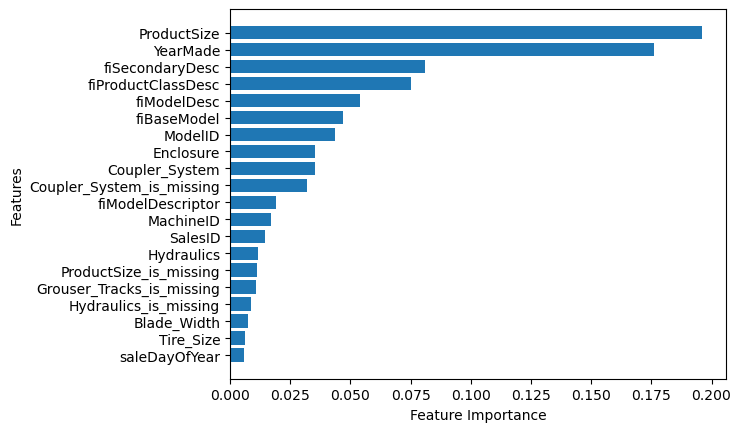

In [29]:
plot_importances(X_train.columns, model.feature_importances_)

Now if we wanted to work with this set more we could. There are certain features that can be dropped. If this was a real life problem getting more data would have helped as well. But for now I think it's time to say goodbye to the Blue Book for Bulldozer Prices notebook!

Bye!